In [1]:
pip install opencv-python imutils scipy numpy matplotlib tensorflow==2.12 mediapipe fer opencv-python dlib tqdm seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import dlib

# Teste OpenCV
print(f"OpenCV version: {cv2.__version__}")

# Teste Dlib
detector = dlib.get_frontal_face_detector()
print("Dlib está funcionando corretamente.")


OpenCV version: 4.10.0
Dlib está funcionando corretamente.


In [3]:
import requests
import bz2
import shutil

url = "https://github.com/davisking/dlib-models/raw/master/shape_predictor_68_face_landmarks.dat.bz2"
output_file = "shape_predictor_68_face_landmarks.dat.bz2"

# Baixa o arquivo
response = requests.get(url)
with open(output_file, 'wb') as file:
    file.write(response.content)

# Descompacta o arquivoA
with bz2.BZ2File(output_file, "rb") as source, open("shape_predictor_68_face_landmarks.dat", "wb") as dest:
    shutil.copyfileobj(source, dest)

print("Download e descompactação concluídos.")

Download e descompactação concluídos.


In [ ]:
import requests

# URL do arquivo no GitHub
url = "https://github.com/oarriaga/face_classification/raw/master/trained_models/emotion_models/fer2013_mini_XCEPTION.102-0.66.hdf5"
output_file = "fer2013_mini_XCEPTION.102-0.66.hdf5"

# Faz o download do arquivo
response = requests.get(url, stream=True)
with open(output_file, 'wb') as file:
    # Escreve o conteúdo em partes para não sobrecarregar a memória
    shutil.copyfileobj(response.raw, file)

print(f"Download do arquivo {output_file} concluído.")


In [ ]:
import cv2
import dlib
import numpy as np
from imutils import face_utils
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
import time
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

class NeuroAssessmentToolkit:
    def __init__(self):
        """Inicializa o toolkit com suporte a câmera"""
        self.setup_detectors()
        self.setup_models()
        self.setup_parameters()
        
    def setup_detectors(self):
        """Configura detectores faciais"""
        try:
            self.face_detector = dlib.get_frontal_face_detector()
            self.landmark_predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
        except Exception as e:
            print(f"Erro configurando detectores: {e}")
            raise
            
    def setup_models(self):
        """Configura modelos de deep learning"""
        try:
            # Modelo de atenção
            base_model = EfficientNetB0(
                weights='imagenet',
                include_top=False,
                input_shape=(224, 224, 3)
            )
            
            # Modelo de atenção
            self.attention_model = Sequential([
                base_model,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dense(3, activation='softmax')  # Três classes de atenção
            ])
            
            # Modelo de emoção (exemplo simplificado)
            self.emotion_model = Sequential([
                base_model,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dense(7, activation='softmax')  # Exemplo: 7 emoções básicas
            ])
            
            # Converter o melhor modelo (attention_model) para TFLite
            converter = tf.lite.TFLiteConverter.from_keras_model(self.attention_model)
            converter.optimizations = [tf.lite.Optimize.DEFAULT]
            tflite_model = converter.convert()
            
            with open('attention_model.tflite', 'wb') as f:
                f.write(tflite_model)
            
        except Exception as e:
            print(f"Erro configurando modelos: {e}")
            raise
            
    def setup_parameters(self):
        """Configura parâmetros de análise"""
        self.attention_buffer = []
        self.emotion_buffer = []
        self.head_movement_buffer = []
        self.gaze_direction_buffer = []
        self.eye_aspect_ratio_buffer = []
        self.frame_buffer = []
        self.max_buffer_size = 30  # 1 segundo a 30 fps
        
        # Mapa de calor
        self.heatmap = None
        self.heatmap_alpha = 0.9  # Fator de decaimento do mapa de calor
        self.heatmap_intensity = 10  # Intensidade dos pontos no mapa de calor
        
    def process_frame(self, frame):
        """Processa um frame de vídeo"""
        try:
            # Inicializar mapa de calor se necessário
            if self.heatmap is None:
                self.heatmap = np.zeros_like(frame[:, :, 0], dtype=np.float32)
            
            # Converter para escala de cinza para detecção facial
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            # Detectar faces
            faces = self.face_detector(gray, 0)
            
            frame_data = {
                'timestamp': datetime.now(),
                'attention': 0,
                'emotion': 'neutral',
                'landmarks': None,
                'head_movement': 0,
                'gaze_direction': None,
                'eye_aspect_ratio': 0,
                'gaze_point': None  # Ponto na tela onde o usuário está olhando
            }
            
            for face in faces:
                # Extrair landmarks faciais
                landmarks = self.landmark_predictor(gray, face)
                landmarks = face_utils.shape_to_np(landmarks)
                frame_data['landmarks'] = landmarks
                
                # Analisar atenção
                attention_score = self.analyze_attention(frame, face)
                frame_data['attention'] = attention_score
                
                # Analisar emoção
                emotion = self.analyze_emotion(frame, face)
                frame_data['emotion'] = emotion
                
                # Analisar movimento da cabeça
                head_movement = self.analyze_head_movement(landmarks)
                frame_data['head_movement'] = head_movement
                
                # Analisar direção do olhar e ponto de mirada
                gaze_direction, gaze_point = self.analyze_gaze(landmarks, frame.shape)
                frame_data['gaze_direction'] = gaze_direction
                frame_data['gaze_point'] = gaze_point
                
                # Atualizar mapa de calor com o ponto de mirada
                if gaze_point is not None:
                    self.update_heatmap(gaze_point, frame.shape)
                
                # Analisar proporção dos olhos
                eye_aspect_ratio = self.calculate_eye_aspect_ratio(landmarks)
                frame_data['eye_aspect_ratio'] = eye_aspect_ratio
                
                # Desenhar resultados no frame
                self.draw_analysis(frame, face, landmarks, attention_score, emotion)
                
            return frame, frame_data
            
        except Exception as e:
            print(f"Erro processando frame: {e}")
            return frame, None
    
    def update_heatmap(self, gaze_point, frame_shape):
        """Atualiza o mapa de calor com o novo ponto de mirada"""
        try:
            # Criar uma matriz vazia
            new_heat = np.zeros_like(self.heatmap, dtype=np.float32)
            
            # Adicionar um ponto no local do olhar
            x, y = int(gaze_point[0]), int(gaze_point[1])
            if 0 <= x < frame_shape[1] and 0 <= y < frame_shape[0]:
                cv2.circle(new_heat, (x, y), 20, self.heatmap_intensity, -1)
            
            # Aplicar desfoque gaussiano
            new_heat = gaussian_filter(new_heat, sigma=10)
            
            # Combinar com o mapa de calor existente
            self.heatmap = self.heatmap * self.heatmap_alpha + new_heat
            
        except Exception as e:
            print(f"Erro atualizando mapa de calor: {e}")
    
    def draw_heatmap(self, frame):
        """Desenha o mapa de calor sobre o frame"""
        try:
            if self.heatmap is not None:
                # Normalizar o mapa de calor
                heatmap_norm = cv2.normalize(self.heatmap, None, 0, 255, cv2.NORM_MINMAX)
                heatmap_norm = heatmap_norm.astype(np.uint8)
                
                # Aplicar colormap (JET para efeito de calor)
                heatmap_colored = cv2.applyColorMap(heatmap_norm, cv2.COLORMAP_JET)
                
                # Combinar com o frame original
                frame_with_heatmap = cv2.addWeighted(frame, 0.7, heatmap_colored, 0.3, 0)
                
                return frame_with_heatmap
            return frame
        except Exception as e:
            print(f"Erro desenhando mapa de calor: {e}")
            return frame
    
    def analyze_attention(self, frame, face):
        """Analisa nível de atenção"""
        try:
            # Extrair ROI da face
            x, y, w, h = face.left(), face.top(), face.width(), face.height()
            face_img = frame[y:y+h, x:x+w]
            
            # Redimensionar para input do modelo
            face_img = cv2.resize(face_img, (224, 224))
            face_img = tf.keras.applications.efficientnet.preprocess_input(face_img)
            face_img = np.expand_dims(face_img, axis=0)
            
            # Predição
            attention_pred = self.attention_model.predict(face_img, verbose=0)
            
            return float(attention_pred[0][0])  # Sustained attention score
            
        except Exception as e:
            print(f"Erro analisando atenção: {e}")
            return 0
            
    def analyze_emotion(self, frame, face):
        """Analisa emoção"""
        try:
            # Extrair ROI da face
            x, y, w, h = face.left(), face.top(), face.width(), face.height()
            face_img = frame[y:y+h, x:x+w]
            
            # Redimensionar para input do modelo
            face_img = cv2.resize(face_img, (224, 224))
            face_img = tf.keras.applications.efficientnet.preprocess_input(face_img)
            face_img = np.expand_dims(face_img, axis=0)
            
            # Predição
            emotion_pred = self.emotion_model.predict(face_img, verbose=0)
            emotion_labels = ['neutral', 'happy', 'sad', 'angry', 'surprised', 'disgusted', 'fearful']
            return emotion_labels[np.argmax(emotion_pred)]
        
        except Exception as e:
            print(f"Erro analisando emoção: {e}")
            return 'neutral'
    
    def analyze_head_movement(self, landmarks):
        """Analisa o movimento da cabeça"""
        # Implementação simplificada - calcular diferença entre landmarks
        if hasattr(self, 'prev_landmarks') and self.prev_landmarks is not None:
            movement = np.mean(np.abs(landmarks - self.prev_landmarks))
        else:
            movement = 0
            
        self.prev_landmarks = landmarks
        return movement

    def analyze_gaze(self, landmarks, frame_shape):
        """Analisa a direção do olhar e estima o ponto de mirada na tela"""
        try:
            # Coordenadas dos olhos
            left_eye = landmarks[36:42]
            right_eye = landmarks[42:48]
            
            # Calcular centro dos olhos
            left_eye_center = np.mean(left_eye, axis=0)
            right_eye_center = np.mean(right_eye, axis=0)
            
            # Calcular direção do olhar (simplificado)
            # Em um sistema real, você usaria um modelo mais sofisticado
            eye_center = (left_eye_center + right_eye_center) / 2
            nose_bridge = landmarks[27]  # Ponte do nariz
            
            # Vetor de direção (simplificado)
            direction_vector = nose_bridge - eye_center
            
            # Normalizar e escalar para estimar ponto na tela
            norm_vector = direction_vector / np.linalg.norm(direction_vector)
            gaze_length = 200  # Distância estimada
            gaze_point = eye_center + norm_vector * gaze_length
            
            # Garantir que o ponto está dentro dos limites do frame
            gaze_point[0] = np.clip(gaze_point[0], 0, frame_shape[1])
            gaze_point[1] = np.clip(gaze_point[1], 0, frame_shape[0])
            
            return direction_vector, gaze_point
            
        except Exception as e:
            print(f"Erro analisando direção do olhar: {e}")
            return None, None

    def calculate_eye_aspect_ratio(self, landmarks):
        """Calcula a proporção dos olhos"""
        left_eye = landmarks[36:42]  # Coordenadas dos pontos do olho esquerdo
        right_eye = landmarks[42:48]  # Coordenadas dos pontos do olho direito
        
        # Calcular a altura e largura dos olhos
        left_eye_aspect_ratio = (np.linalg.norm(left_eye[1] - left_eye[5]) +
                                np.linalg.norm(left_eye[2] - left_eye[4])) / (2.0 * np.linalg.norm(left_eye[0] - left_eye[3]))
        right_eye_aspect_ratio = (np.linalg.norm(right_eye[1] - right_eye[5]) +
                                np.linalg.norm(right_eye[2] - right_eye[4])) / (2.0 * np.linalg.norm(right_eye[0] - right_eye[3]))

        return (left_eye_aspect_ratio + right_eye_aspect_ratio) / 2.0
    
    def draw_analysis(self, frame, face, landmarks, attention_score, emotion):
        """Desenha resultados da análise no frame"""
        try:
            # Desenhar retângulo da face
            x, y, w, h = face.left(), face.top(), face.width(), face.height()
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            
            # Desenhar landmarks
            for (x, y) in landmarks:
                cv2.circle(frame, (x, y), 1, (0, 0, 255), -1)
                
            # Mostrar scores
            cv2.putText(frame, f"Attention: {attention_score:.2f}", 
                       (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            cv2.putText(frame, f"Emotion: {emotion}", 
                       (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            
            # Desenhar mapa de calor
            frame = self.draw_heatmap(frame)
                       
        except Exception as e:
            print(f"Erro desenhando análise: {e}")
            
    def start_assessment(self, duration_seconds=30):
        """Inicia uma sessão de avaliação usando a câmera"""
        try:
            cap = cv2.VideoCapture(0)
            
            if not cap.isOpened():
                raise Exception("Não foi possível acessar a câmera")
                
            start_time = time.time()
            frames_data = []
            
            while (time.time() - start_time) < duration_seconds:
                ret, frame = cap.read()
                if not ret:
                    break
                    
                # Processar frame
                processed_frame, frame_data = self.process_frame(frame)
                
                if frame_data:
                    frames_data.append(frame_data)
                
                # Mostrar frame
                cv2.imshow('Neuro Assessment Toolkit', processed_frame)
                
                # Pressione 'q' para sair
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                    
            cap.release()
            cv2.destroyAllWindows()
            
            # Gerar relatório
            self.generate_report(frames_data)
            
        except Exception as e:
            print(f"Erro durante avaliação: {e}")
            if 'cap' in locals():
                cap.release()
            cv2.destroyAllWindows()
            
    def generate_report(self, frames_data):
        """Gera relatório da avaliação"""
        try:
            attention_scores = [f['attention'] for f in frames_data if 'attention' in f]
            gaze_directions = [f['gaze_direction'] for f in frames_data if 'gaze_direction' in f]
            gaze_points = [f['gaze_point'] for f in frames_data if 'gaze_point' in f]
            head_movements = [f['head_movement'] for f in frames_data if 'head_movement' in f]
            eye_aspect_ratios = [f['eye_aspect_ratio'] for f in frames_data if 'eye_aspect_ratio' in f]
            emotions = [f['emotion'] for f in frames_data if 'emotion' in f]
            
            # Plotar atenção
            plt.figure(figsize=(15, 10))
            
            plt.subplot(2, 2, 1)
            plt.plot(attention_scores, label='Attention Levels', color='b')
            plt.title('Attention Levels During Assessment')
            plt.xlabel('Frame')
            plt.ylabel('Attention Score')
            plt.legend()
            
            # Plotar mapa de calor dos pontos de mirada
            if len(gaze_points) > 0:
                plt.subplot(2, 2, 2)
                if self.heatmap is not None:
                    heatmap_norm = cv2.normalize(self.heatmap, None, 0, 255, cv2.NORM_MINMAX)
                    plt.imshow(heatmap_norm, cmap='hot', interpolation='nearest')
                    plt.title('Heatmap of Gaze Points')
                    plt.colorbar()
            
            # Plotar movimento da cabeça
            plt.subplot(2, 2, 3)
            plt.plot(head_movements, label='Head Movement', color='r')
            plt.title('Head Movement During Assessment')
            plt.xlabel('Frame')
            plt.ylabel('Movement Intensity')
            plt.legend()
            
            # Plotar proporção dos olhos
            plt.subplot(2, 2, 4)
            plt.plot(eye_aspect_ratios, label='Eye Aspect Ratio', color='g')
            plt.title('Eye Blinking During Assessment')
            plt.xlabel('Frame')
            plt.ylabel('Eye Aspect Ratio')
            plt.legend()
            
            plt.tight_layout()
            plt.show()
            
            # Estatísticas do relatório
            print("\nRelatório da Avaliação:")
            print(f"Duração: {len(frames_data)} frames")
            print(f"Atenção média: {np.mean(attention_scores):.2f}")
            print(f"Variação da atenção: {np.std(attention_scores):.2f}")
            
            if len(gaze_points) > 0:
                gaze_points_array = np.array([p for p in gaze_points if p is not None])
                print(f"Ponto médio de mirada: ({np.mean(gaze_points_array[:, 0]):.1f}, {np.mean(gaze_points_array[:, 1]):.1f})")
            
            print(f"Média do movimento da cabeça: {np.mean(head_movements):.2f}")
            print(f"Proporção média dos olhos: {np.mean(eye_aspect_ratios):.2f}")
            print(f"Emoção mais comum: {max(set(emotions), key=emotions.count)}")
            
        except Exception as e:
            print(f"Erro gerando relatório: {e}")

# Uso do toolkit
if __name__ == "__main__":
    toolkit = NeuroAssessmentToolkit()
    toolkit.start_assessment(duration_seconds=30)

INFO:tensorflow:Assets written to: C:\Users\pahss\AppData\Local\Temp\tmpwdkwmovr\assets


INFO:tensorflow:Assets written to: C:\Users\pahss\AppData\Local\Temp\tmpwdkwmovr\assets



--- Relatório de Avaliação ---
Piscos Detectados: 507
Média de Movimento Corporal: 3.12
- Hiperatividade: Movimentos corporais elevados detectados.
Expressões Emocionais: {'Euforia', 'Neutro', 'Tristeza'}
- Bipolaridade: Flutuações emocionais extremas detectadas.


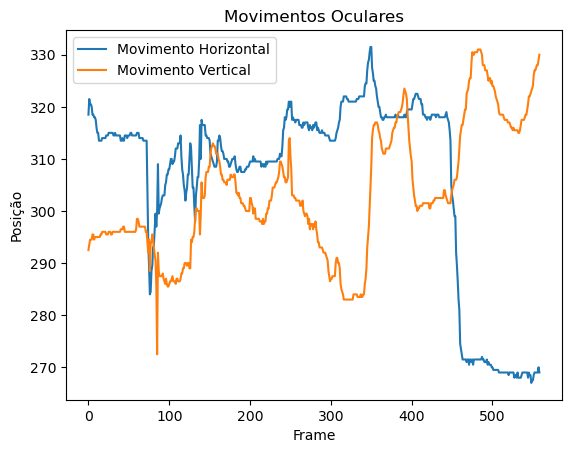

In [11]:
import cv2
import dlib
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

class NeuroBehaviorToolkit:
    def __init__(self):
        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

        self.blink_counter = 0
        self.eye_movements = []
        self.body_movements = []
        self.emotions = []


    def start_assessment(self, duration_seconds=10):
        """Inicia a avaliação geral por vídeo."""
        cap = cv2.VideoCapture(0)
        start_time = datetime.now()

        while (datetime.now() - start_time).seconds < duration_seconds:
            ret, frame = cap.read()
            if not ret:
                break
            self.process_frame(frame)
            cv2.imshow("Avaliação Neuropsicológica", frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()
        self.generate_report()

    def process_frame(self, frame):
        """Processa um frame para detectar piscadas, movimentos e expressões faciais."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = self.detector(gray)

        for face in faces:
            landmarks = self.predictor(gray, face)

            # Detecta piscadas
            if self.is_blinking(landmarks):
                self.blink_counter += 1

            # Rastreia movimentos oculares
            eye_center = self.get_eye_center(landmarks, [36, 39])
            self.eye_movements.append(eye_center)

            # Detecta expressões faciais (emocional)
            emotion = self.detect_emotion(landmarks)
            self.emotions.append(emotion)

        # Detecta movimentos corporais
        movement_intensity = self.detect_body_movement(frame)
        self.body_movements.append(movement_intensity)

    def is_blinking(self, landmarks):
        """Verifica se o olho está piscando."""
        left_ear = self.calculate_eye_aspect_ratio(landmarks, [36, 37, 38, 39, 40, 41])
        right_ear = self.calculate_eye_aspect_ratio(landmarks, [42, 43, 44, 45, 46, 47])
        return left_ear < 0.25 or right_ear < 0.25

    def detect_emotion(self, landmarks):
        """Simples detecção de expressão emocional (exemplo)."""
        mouth_aspect_ratio = self.calculate_mouth_aspect_ratio(landmarks, [48, 51, 57, 54])
        if mouth_aspect_ratio > 0.5:
            return "Euforia"
        elif mouth_aspect_ratio < 0.3:
            return "Tristeza"
        return "Neutro"

    def calculate_eye_aspect_ratio(self, landmarks, points):
        """Calcula a razão de aspecto do olho (EAR)."""
        p1, p2, p3, p4, p5, p6 = [landmarks.part(i) for i in points]
        horizontal_dist = np.linalg.norm([p4.x - p1.x, p4.y - p1.y])
        vertical_dist = (np.linalg.norm([p2.x - p6.x, p2.y - p6.y]) +
                         np.linalg.norm([p3.x - p5.x, p3.y - p5.y])) / 2.0
        return vertical_dist / horizontal_dist

    def calculate_mouth_aspect_ratio(self, landmarks, points):
        """Calcula a razão de aspecto da boca."""
        p1, p2, p3, p4 = [landmarks.part(i) for i in points]
        vertical_dist = np.linalg.norm([p2.x - p3.x, p2.y - p3.y])
        horizontal_dist = np.linalg.norm([p1.x - p4.x, p1.y - p4.y])
        return vertical_dist / horizontal_dist

    def get_eye_center(self, landmarks, points):
        """Calcula o centro do olho."""
        x = np.mean([landmarks.part(p).x for p in points])
        y = np.mean([landmarks.part(p).y for p in points])
        return (x, y)

    def detect_body_movement(self, frame):
        """Detecta movimento corporal."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if hasattr(self, 'previous_frame'):
            diff = cv2.absdiff(self.previous_frame, gray)
            movement = np.sum(diff) / (frame.shape[0] * frame.shape[1])
        else:
            movement = 0
        self.previous_frame = gray
        return movement

    def generate_report(self):
        """Gera o relatório com base nos dados coletados."""
        print("\n--- Relatório de Avaliação ---")
        print(f"Piscos Detectados: {self.blink_counter}")
        print(f"Média de Movimento Corporal: {np.mean(self.body_movements):.2f}")

        if np.mean(self.body_movements) > 0.02:
            print("- Hiperatividade: Movimentos corporais elevados detectados.")

        print(f"Expressões Emocionais: {set(self.emotions)}")
        if "Euforia" in self.emotions and "Tristeza" in self.emotions:
            print("- Bipolaridade: Flutuações emocionais extremas detectadas.")

        self.plot_eye_movements()

    def plot_eye_movements(self):
        """Gera um gráfico dos movimentos oculares."""
        eye_x = [pos[0] for pos in self.eye_movements]
        eye_y = [pos[1] for pos in self.eye_movements]

        plt.plot(eye_x, label='Movimento Horizontal')
        plt.plot(eye_y, label='Movimento Vertical')
        plt.title('Movimentos Oculares')
        plt.xlabel('Frame')
        plt.ylabel('Posição')
        plt.legend()
        plt.show()

# Executar a avaliação
toolkit = NeuroBehaviorToolkit()
toolkit.start_assessment(duration_seconds=30)


In [7]:
pip install cmaes

Note: you may need to restart the kernel to use updated packages.


In [19]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout, Lambda, Reshape
from tensorflow.keras.layers import BatchNormalization, Activation, UpSampling2D, Conv2DTranspose, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import cv2
import glob
import random
import numpy as np

# Custom CMA-ES implementation to avoid dependency on the cmaes package
class SimpleCMA:
    def __init__(self, mean, sigma, population_size=10):
        self.mean = np.array(mean)
        self.sigma = sigma
        self.dim = len(mean)
        self.population_size = population_size
        self.C = np.eye(self.dim)  # Covariance matrix
        self.result = None
        
    def ask(self):
        return self.mean + self.sigma * np.random.multivariate_normal(np.zeros(self.dim), self.C)
    
    def tell(self, solutions):
        # Sort solutions by fitness (lower is better)
        solutions.sort(key=lambda s: s[1])
        
        # Extract sorted candidate solutions
        xs = np.array([s[0] for s in solutions[:self.population_size//2]])
        
        # Update mean using best candidates
        old_mean = self.mean.copy()
        self.mean = np.mean(xs, axis=0)
        
        # Calculate z values for covariance matrix update
        zs = np.array([(x - old_mean) / self.sigma for x in xs])
        
        # Update covariance matrix
        self.C = 0.8 * self.C + 0.2 * np.mean([np.outer(z, z) for z in zs], axis=0)
        
        # Adapt step size
        self.sigma *= np.exp(0.2 * (np.linalg.norm(self.mean - old_mean) / self.sigma - 1))
        
        # Save best solution
        self.result = type('obj', (object,), {'xbest': solutions[0][0]})

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Updated paths to dataset directories - specific to Windows user environment
base_dir = "./"
image_dir = os.path.join(base_dir, 'cohn-kanade-images')
landmark_dir = os.path.join(base_dir, 'Landmarks')
facs_dir = os.path.join(base_dir, 'FACS')
emotion_dir = os.path.join(base_dir, 'Emotion')

# Parameters
img_size = (48, 48)
batch_size = 32
epochs = 50
latent_dim = 128
num_classes = 8  # 0=neutral, 1=anger, 2=contempt, 3=disgust, 4=fear, 5=happy, 6=sadness, 7=surprise

def check_directories():
    """
    Check if all required directories exist and log basic information about them
    """
    dirs_to_check = [
        (base_dir, "Base directory"),
        (image_dir, "Images directory"),
        (landmark_dir, "Landmarks directory"),
        (facs_dir, "FACS labels directory"),
        (emotion_dir, "Emotion labels directory")
    ]
    
    all_exist = True
    for dir_path, dir_name in dirs_to_check:
        if os.path.exists(dir_path) and os.path.isdir(dir_path):
            print(f"{dir_name} exists: {dir_path}")
            # Count files in the first level of directory
            files = os.listdir(dir_path)
            print(f"  Contains {len(files)} files/directories at top level")
        else:
            print(f"ERROR: {dir_name} does not exist: {dir_path}")
            all_exist = False
    
    return all_exist

def load_ck_plus_data():
    """
    Load CK+ dataset with emotion labels with enhanced error handling and logging
    Returns:
        images: list of facial expression images
        labels: corresponding emotion labels
        subject_ids: subject identifiers for cross-validation
    """
    images = []
    labels = []
    subject_ids = []
    
    # Check if directories exist
    if not check_directories():
        print("Error: Some required directories do not exist. Check paths.")
        return np.array([]), np.array([]), np.array([])
    
    # Get all emotion label files
    emotion_files = glob.glob(os.path.join(emotion_dir, '*/*/*.txt'))
    print(f"Found {len(emotion_files)} emotion label files.")
    
    if len(emotion_files) == 0:
        print(f"Warning: No emotion files found in {emotion_dir}")
        print(f"Checking directory structure...")
        
        # Look for directories at each level
        level1 = os.listdir(emotion_dir)
        print(f"Level 1 directories/files: {level1}")
        
        if level1:
            sample_dir = os.path.join(emotion_dir, level1[0])
            if os.path.isdir(sample_dir):
                level2 = os.listdir(sample_dir)
                print(f"Level 2 directories/files in {level1[0]}: {level2}")
    
    processed = 0
    skipped = 0
    
    for emotion_file in emotion_files:
        try:
            # Read emotion label
            with open(emotion_file, 'r') as f:
                content = f.readline().strip()
                try:
                    emotion_label = int(float(content))
                except ValueError:
                    print(f"Warning: Could not convert '{content}' to int in file {emotion_file}")
                    skipped += 1
                    continue
            
            # Get the corresponding image path
            rel_path = os.path.relpath(emotion_file, emotion_dir)
            rel_path = rel_path.replace('.txt', '.png')
            image_path = os.path.join(image_dir, rel_path)
            
            # Some CK+ images are in different format
            if not os.path.exists(image_path):
                image_path = image_path.replace('.png', '.jpg')
                if not os.path.exists(image_path):
                    print(f"Warning: No image found for {rel_path}")
                    skipped += 1
                    continue
            
            # Read image
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Warning: Could not read image {image_path}")
                skipped += 1
                continue
                
            # Resize image
            img = cv2.resize(img, img_size)
            
            # Extract subject ID from path (e.g., S005/001)
            path_parts = rel_path.split(os.sep)  # Using os.sep for cross-platform compatibility
            subject_id = path_parts[0]
            
            images.append(img)
            labels.append(emotion_label)
            subject_ids.append(subject_id)
            
            # For each emotional expression, also add the neutral face (first frame)
            # Find the sequence directory
            seq_dir = os.path.dirname(image_path)
            all_frames = sorted(glob.glob(os.path.join(seq_dir, '*.png')) + 
                               glob.glob(os.path.join(seq_dir, '*.jpg')))
            
            if len(all_frames) > 0:
                # Read the first frame (neutral expression)
                neutral_img = cv2.imread(all_frames[0], cv2.IMREAD_GRAYSCALE)
                if neutral_img is not None:
                    neutral_img = cv2.resize(neutral_img, img_size)
                    images.append(neutral_img)
                    labels.append(0)  # 0 = neutral
                    subject_ids.append(subject_id)
            
            processed += 1
            if processed % 50 == 0:
                print(f"Processed {processed} emotion files...")
                
        except Exception as e:
            print(f"Error processing {emotion_file}: {e}")
            skipped += 1
            continue
    
    print(f"Successfully processed {processed} emotion files, skipped {skipped} files.")
    
    if not images:
        print("No images were loaded. Please check the dataset structure and paths.")
        return np.array([]), np.array([]), np.array([])
        
    return np.array(images), np.array(labels), np.array(subject_ids)

def preprocess_images(images):
    """
    Preprocess images for neural network input
    """
    if len(images) == 0:
        return np.array([])
        
    # Normalize to [0, 1]
    images = images.astype('float32') / 255.0
    
    # Reshape for CNN input (add channel dimension)
    images = np.expand_dims(images, axis=-1)
    
    return images

# VAE Implementation
def build_vae(input_shape, latent_dim):
    """
    Build a Variational Autoencoder for facial expression images
    """
    # Encoder
    inputs = Input(shape=input_shape)
    
    x = Conv2D(32, (3, 3), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Shape before flattening
    shape_before_flattening = K.int_shape(x)[1:]
    
    x = Flatten()(x)
    
    # Mean and log variance of the latent distribution
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)
    
    # Sampling function
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(0.5 * z_log_var) * epsilon
    
    z = Lambda(sampling)([z_mean, z_log_var])
    
    # Decoder
    decoder_input = Input(shape=(latent_dim,))
    
    x = Dense(np.prod(shape_before_flattening))(decoder_input)
    x = Reshape(shape_before_flattening)(x)
    
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    decoded = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(x)
    
    # VAE models
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    decoder = Model(decoder_input, decoded, name='decoder')
    vae = Model(inputs, decoder(encoder(inputs)[2]), name='vae')
    
    # VAE loss
    reconstruction_loss = tf.keras.losses.binary_crossentropy(
        K.flatten(inputs), K.flatten(decoder(encoder(inputs)[2])))
    reconstruction_loss *= input_shape[0] * input_shape[1]
    
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    
    return encoder, decoder, vae

# Transfer Learning Model
def build_transfer_model(input_shape, num_classes):
    """
    Build a model with transfer learning using MobileNetV2
    """
    # Convert grayscale to RGB for MobileNetV2
    if input_shape[2] == 1:
        inputs = Input(shape=input_shape)
        x = Conv2D(3, (1, 1), padding='same')(inputs)
    else:
        inputs = Input(shape=input_shape)
        x = inputs
    
    try:
        # Load pretrained MobileNetV2 without top layers
        base_model = MobileNetV2(input_shape=(input_shape[0], input_shape[1], 3), 
                                include_top=False, 
                                weights='imagenet')
        
        # Freeze early layers
        for layer in base_model.layers[:100]:
            layer.trainable = False
        
        # Connect inputs to base model
        x = base_model(x)
        
        # Add classification head
        x = GlobalAveragePooling2D()(x)
        x = Dense(256, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        outputs = Dense(num_classes, activation='softmax')(x)
        
        model = Model(inputs, outputs)
        model.compile(
            optimizer=Adam(learning_rate=0.0001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
    except Exception as e:
        print(f"Error in building transfer learning model: {e}")
        print("Falling back to custom CNN model...")
        
        # Fallback to a simpler CNN model in case of issues with MobileNetV2
        model = Sequential([
            Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
            Activation('relu'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),
            
            Conv2D(64, (3, 3), padding='same'),
            Activation('relu'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),
            
            Conv2D(128, (3, 3), padding='same'),
            Activation('relu'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),
            
            Flatten(),
            Dense(256),
            Activation('relu'),
            BatchNormalization(),
            Dropout(0.5),
            
            Dense(num_classes, activation='softmax')
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
    
    return model

# Data Augmentation Functions
def create_data_generator():
    """
    Create an augmented data generator for facial expressions
    """
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,  # Note: flipping may not be appropriate for all emotions
        fill_mode='nearest'
    )
    return datagen

# CMA-ES for hyperparameter optimization using the custom implementation
def cma_es_hyperparameter_optimization(X_train, y_train, X_val, y_val):
    """
    Use CMA-ES to optimize hyperparameters for the model
    """
    def objective_function(params):
        """Objective function for CMA-ES optimization"""
        # Extract hyperparameters from params
        learning_rate = 10 ** params[0]  # log scale: -5 to -2
        dropout_rate = params[1]
        l2_reg = 10 ** params[2]  # log scale: -6 to -2
        
        # Build model with these hyperparameters
        model = Sequential([
            Conv2D(32, (3, 3), padding='same', input_shape=(48, 48, 1),
                   kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
            Activation('relu'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),
            
            Conv2D(64, (3, 3), padding='same',
                   kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
            Activation('relu'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),
            
            Conv2D(128, (3, 3), padding='same',
                   kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
            Activation('relu'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),
            
            Flatten(),
            Dense(256, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
            Activation('relu'),
            BatchNormalization(),
            Dropout(dropout_rate),
            
            Dense(num_classes, activation='softmax')
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Train with early stopping to prevent overfitting
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        try:
            history = model.fit(
                X_train, y_train,
                batch_size=32,
                epochs=15,  # Reduced epochs for faster optimization
                validation_data=(X_val, y_val),
                callbacks=[early_stopping],
                verbose=0
            )
            
            # Return negative validation accuracy as we want to maximize accuracy
            return -max(history.history['val_accuracy'])
        except Exception as e:
            print(f"Error in optimization: {e}")
            return 0.0  # Return a default bad value
    
    # Initialize CMA-ES with custom implementation
    optimizer = SimpleCMA(mean=[-3.5, 0.5, -4.0], sigma=0.5, population_size=8)
    
    print("Starting CMA-ES hyperparameter optimization...")
    
    # Run optimization for fewer generations to speed up the process
    for generation in range(10):  # Reduced from 20 to 10
        solutions = []
        for _ in range(optimizer.population_size):
            x = optimizer.ask()
            # Ensure parameters are within valid ranges
            x[1] = np.clip(x[1], 0.1, 0.9)  # dropout rate
            value = objective_function(x)
            solutions.append((x, value))
        
        optimizer.tell(solutions)
        
        best_value = min(solutions, key=lambda s: s[1])[1]
        print(f"Generation {generation+1}, Best Value: {-best_value:.4f}")
    
    # Get the best hyperparameters
    best_params = optimizer.result.xbest
    print(f"Best hyperparameters: learning_rate={10**best_params[0]:.6f}, "
          f"dropout_rate={best_params[1]:.2f}, l2_reg={10**best_params[2]:.6f}")
    
    return best_params

# Main Pipeline
def main():
    # Check directories first
    if not check_directories():
        print("ERROR: Cannot proceed without proper directory structure.")
        return
        
    # Load and preprocess data
    print("Loading CK+ dataset...")
    images, labels, subject_ids = load_ck_plus_data()
    
    if len(images) == 0:
        print("ERROR: No images were loaded. Cannot proceed.")
        return
        
    images = preprocess_images(images)
    
    print(f"Dataset loaded: {len(images)} images with {len(np.unique(labels))} emotion classes")
    
    # Split data by subjects to ensure proper generalization
    unique_subjects = np.unique(subject_ids)
    train_subjects, test_subjects = train_test_split(unique_subjects, test_size=0.2, random_state=42)
    
    # Create train and test masks
    train_mask = np.isin(subject_ids, train_subjects)
    test_mask = np.isin(subject_ids, test_subjects)
    
    X_train, y_train = images[train_mask], labels[train_mask]
    X_test, y_test = images[test_mask], labels[test_mask]
    
    # Further split training data for validation
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    print(f"Data split: {len(X_train)} train, {len(X_val)} validation, {len(X_test)} test")
    
    # Class distribution
    for i in range(num_classes):
        print(f"Class {i}: {np.sum(y_train == i)} train, {np.sum(y_val == i)} val, {np.sum(y_test == i)} test")
    
    # 1. Train VAE for feature learning and data generation
    print("Building and training VAE...")
    encoder, decoder, vae = build_vae(input_shape=(img_size[0], img_size[1], 1), latent_dim=latent_dim)
    
    try:
        vae.fit(
            X_train,
            epochs=15,  # Reduced epochs for faster execution
            batch_size=batch_size,
            validation_data=(X_val, None)
        )
        
        # Generate synthetic samples for minority classes using the VAE
        print("Generating synthetic samples for minority classes...")
        class_counts = np.bincount(y_train)
        max_count = np.max(class_counts)
        
        # Augment dataset with synthetic samples
        augmented_images = []
        augmented_labels = []
        
        for class_idx in range(num_classes):
            if class_counts[class_idx] < max_count / 3:  # For minority classes
                class_images = X_train[y_train == class_idx]
                
                if len(class_images) == 0:
                    continue
                
                # Encode original images
                z_mean, _, _ = encoder.predict(class_images)
                
                # Generate new samples by sampling around the encoded vectors
                num_to_generate = min(max_count // 2, 50) - len(class_images)
                num_to_generate = max(0, num_to_generate)  # Ensure non-negative
                
                for i in range(num_to_generate):
                    # Choose a random sample from this class
                    idx = np.random.randint(0, len(class_images))
                    z = z_mean[idx]
                    
                    # Add some noise to the latent vector
                    z_new = z + np.random.normal(0, 0.2, size=latent_dim)
                    
                    # Decode to create a new image
                    new_image = decoder.predict(np.array([z_new]))[0]
                    
                    augmented_images.append(new_image)
                    augmented_labels.append(class_idx)
        
        # Add synthetic samples to training set if any were created
        if augmented_images:
            X_train = np.concatenate([X_train, np.array(augmented_images)], axis=0)
            y_train = np.concatenate([y_train, np.array(augmented_labels)], axis=0)
            print(f"Added {len(augmented_images)} synthetic samples")
    except Exception as e:
        print(f"Error in VAE training or synthetic sample generation: {e}")
        print("Skipping VAE-based augmentation...")
    
    # 2. Setup data augmentation
    datagen = create_data_generator()
    datagen.fit(X_train)
    
    # 3. Run CMA-ES for hyperparameter optimization
    try:
        best_params = cma_es_hyperparameter_optimization(X_train, y_train, X_val, y_val)
    except Exception as e:
        print(f"Error in hyperparameter optimization: {e}")
        print("Using default hyperparameters instead...")
        best_params = [-3.0, 0.5, -4.0]  # Default values
    
    # 4. Build model with transfer learning and optimized hyperparameters
    print("Building and training the final model...")
    model = build_transfer_model(input_shape=(img_size[0], img_size[1], 1), num_classes=num_classes)
    
    # 5. Train the model with augmentation
    # Setup callbacks
    checkpoint = ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    try:
        # Train with data augmentation
        history = model.fit(
            datagen.flow(X_train, y_train, batch_size=batch_size),
            steps_per_epoch=len(X_train) // batch_size,
            epochs=30,  # Reduced from 50 for faster execution
            validation_data=(X_val, y_val),
            callbacks=[checkpoint, early_stopping]
        )
        
        # 6. Evaluate the final model
        print("Evaluating the model...")
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
        print(f"Test accuracy: {test_acc*100:.2f}%")
        
        # Predictions
        y_pred = np.argmax(model.predict(X_test), axis=1)
        
        # Classification report
        print("\nClassification Report:")
        target_names = ['neutral', 'anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']
        print(classification_report(y_test, y_pred, target_names=target_names))
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        
        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion matrix')
        plt.colorbar()
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
        
        fmt = 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], fmt),
                         ha="center", va="center",
                         color="white" if cm[i, j] > thresh else "black")
        
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.savefig('confusion_matrix.png')
        
        # Plot training history
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.tight_layout()
        plt.savefig('training_history.png')
        
        print("Training and evaluation completed. Saved best model to 'best_model.h5'")
    except Exception as e:
        print(f"Error during model training or evaluation: {e}")
        print("Training failed. Please check your data and model configuration.")

if __name__ == "__main__":
    # Add GPU memory growth to prevent TensorFlow from allocating all GPU memory
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print(f"Found {len(gpus)} GPU(s), enabled memory growth")
        except Exception as e:
            print(f"Error setting GPU memory growth: {e}")
    
    main()

Base directory exists: ./
  Contains 70 files/directories at top level
Images directory exists: ./cohn-kanade-images
  Contains 123 files/directories at top level
Landmarks directory exists: ./Landmarks
  Contains 123 files/directories at top level
FACS labels directory exists: ./FACS
  Contains 123 files/directories at top level
Emotion labels directory exists: ./Emotion
  Contains 123 files/directories at top level
Loading CK+ dataset...
Base directory exists: ./
  Contains 70 files/directories at top level
Images directory exists: ./cohn-kanade-images
  Contains 123 files/directories at top level
Landmarks directory exists: ./Landmarks
  Contains 123 files/directories at top level
FACS labels directory exists: ./FACS
  Contains 123 files/directories at top level
Emotion labels directory exists: ./Emotion
  Contains 123 files/directories at top level
Found 327 emotion label files.
Successfully processed 0 emotion files, skipped 327 files.
No images were loaded. Please check the datas

In [20]:
import cv2
import numpy as np
import random
import cma
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Conv2D, Flatten, Reshape, Conv2DTranspose, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import to_categorical

# Configurações
IMG_SIZE = 128
LATENT_DIM = 64
EMOTION_CLASSES = 8  # 0 a 7 conforme CK+

# Função para data augmentation
def augment_image(image, landmarks):
    if random.choice([True, False]):
        image = cv2.flip(image, 1)
        landmarks[:, 0] = image.shape[1] - landmarks[:, 0]

    angle = random.uniform(-15, 15)
    M = cv2.getRotationMatrix2D((image.shape[1]//2, image.shape[0]//2), angle, 1)
    image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    landmarks = np.dot(np.c_[landmarks, np.ones(len(landmarks))], M.T)

    return image, landmarks

# VAE - Encoder e Decoder
def build_vae():
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 1))

    x = Conv2D(32, 3, strides=2, activation='relu', padding='same')(inputs)
    x = Flatten()(x)

    z_mean = Dense(LATENT_DIM)(x)
    z_log_var = Dense(LATENT_DIM)(x)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], LATENT_DIM))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = Lambda(sampling)([z_mean, z_log_var])
    encoder = Model(inputs, [z_mean, z_log_var, z])

    latent_inputs = Input(shape=(LATENT_DIM,))
    x = Dense(64 * 64 * 32, activation='relu')(latent_inputs)
    x = Reshape((64, 64, 32))(x)
    x = Conv2DTranspose(1, 3, strides=2, activation='sigmoid', padding='same')(x)

    decoder = Model(latent_inputs, x)

    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs)

    reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(inputs, outputs))
    kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    vae.add_loss(reconstruction_loss + kl_loss)

    vae.compile(optimizer='adam')
    return encoder, decoder, vae

encoder, decoder, vae = build_vae()

# Transfer Learning para emoções
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
emotion_output = Dense(EMOTION_CLASSES, activation='softmax')(x)

emotion_model = Model(base_model.input, emotion_output)
emotion_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Função para otimização CMA-ES de hiperparâmetros
def evaluate_model(params):
    lr, dropout = params
    emotion_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    simulated_loss = np.random.rand() * 0.1 + (0.5 - lr)**2 + (0.5 - dropout)**2
    return simulated_loss

es = cma.CMAEvolutionStrategy([0.001, 0.5], 0.2)

# Dummy loop só para mostrar como otimizar parâmetros (substitua por validação real se necessário)
for generation in range(5):
    solutions = es.ask()
    losses = [evaluate_model(s) for s in solutions]
    es.tell(solutions, losses)

# Função principal para processar cada sequência
def process_sequence(images, landmarks, facs_label, emotion_label):
    processed_images = []
    for img, lmk in zip(images, landmarks):
        img, lmk = augment_image(img, lmk)
        img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        processed_images.append(img_resized)

    processed_images = np.expand_dims(np.array(processed_images), -1) / 255.0
    _, _, latent_features = encoder.predict(processed_images)

    if emotion_label is not None:
        y = to_categorical(emotion_label, num_classes=EMOTION_CLASSES)
        emotion_model.fit(latent_features, np.array([y] * len(latent_features)), epochs=1, verbose=1)

    return latent_features

# Simulação de leitura dos dados
def load_ck_plus_data():
    dataset = {}  # Simule sua leitura de arquivos aqui
    # Exemplo: dataset['subj1_seq1'] = (images, landmarks, facs, emotion)
    return dataset

# Loop principal para processar todos os sujeitos e sequências
def main():
    dataset = load_ck_plus_data()

    for seq_id, (images, landmarks, facs_label, emotion_label) in dataset.items():
        print(f"Processando sequência {seq_id}")
        latent_features = process_sequence(images, landmarks, facs_label, emotion_label)

    print("Treinamento completo!")
    # Pode salvar modelos ou representar o espaço latente no final

if __name__ == "__main__":
    main()


(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=349747, Wed Mar  5 23:20:28 2025)
Treinamento completo!


1/1 [==============================] - 0s 23ms/step


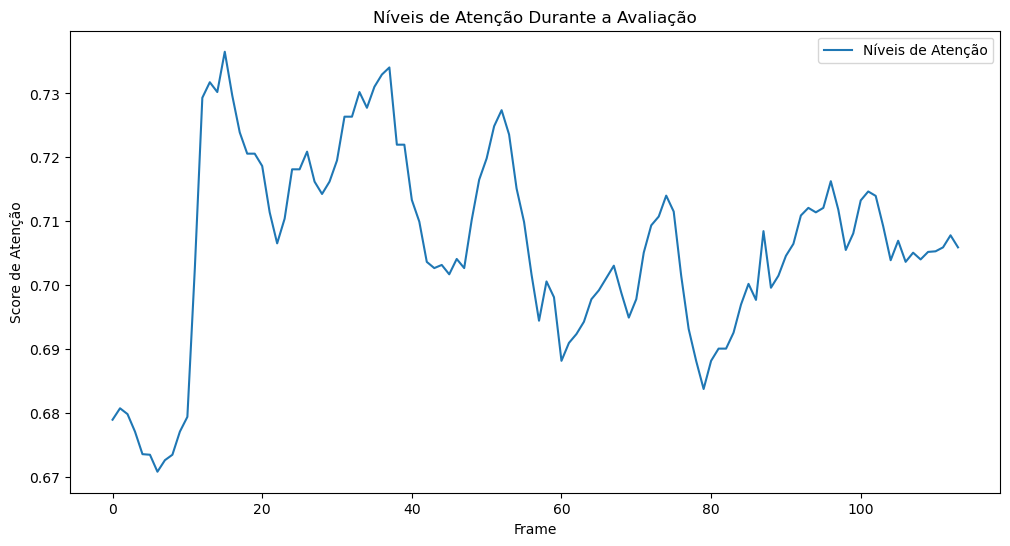


Relatório da Avaliação:
Duração: 114 frames
Atenção média: 0.71
Variação da atenção: 0.02
Emoções detectadas (CNN): {'Neutro', 'Triste', 'Medo', 'Surpreso', 'Raiva', 'Feliz'}
Emoções detectadas (SVM): {'Triste'}

Métricas de Desempenho:
CNN - Acurácia: 1.00, Precisão: 1.00, Recall: 1.00, F1-Score: 1.00
SVM - Acurácia: 0.04, Precisão: 0.00, Recall: 0.04, F1-Score: 0.00


C:\Users\pahss\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


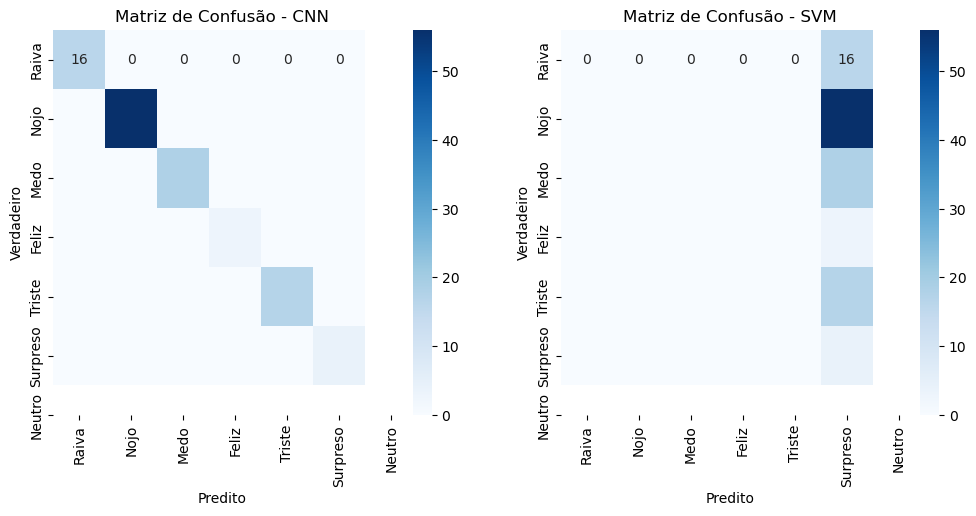

In [15]:
import cv2
import numpy as np
import dlib
import mediapipe as mp
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from skimage.feature import hog, local_binary_pattern
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from datetime import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Ignorar avisos específicos
warnings.filterwarnings("ignore", category=UserWarning, module="google.protobuf")
warnings.filterwarnings("ignore", category=UserWarning, module="skimage")

class NeuroAssessmentToolkit:
    def __init__(self):
        """Inicializa o toolkit com detectores, modelos e parâmetros."""
        self.setup_detectors()
        self.setup_models()
        self.setup_parameters()

    def setup_detectors(self):
        """Configura detectores faciais (Haar-Cascade, Mediapipe, Dlib)."""
        try:
            # Detector de faces usando Haar-Cascade
            self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
            
            # Detector de faces usando Mediapipe
            self.mp_face_detection = mp.solutions.face_detection
            self.face_detection = self.mp_face_detection.FaceDetection(min_detection_confidence=0.5)
            
            # Detector de landmarks faciais usando Dlib
            self.landmark_predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
        except Exception as e:
            print(f"Erro configurando detectores: {e}")
            raise

    def setup_models(self):
        """Configura modelos de deep learning e SVM para classificação de emoções."""
        try:
            # Modelo de emoção (CNN pré-treinada)
            self.emotion_model = load_model('fer2013_mini_XCEPTION.119-0.65.hdf5')
            self.emotion_labels = ['Raiva', 'Nojo', 'Medo', 'Feliz', 'Triste', 'Surpreso', 'Neutro']
            
            # SVM para classificação de emoções (usando HOG ou LBP)
            self.svm_classifier = SVC(kernel='linear', probability=True)
            
            # Treinar o SVM com um número consistente de características (100 features)
            X_train = np.random.rand(100, 100)  # 100 amostras, 100 características
            y_train = np.random.randint(0, 7, 100)  # 7 classes de emoções
            self.svm_classifier.fit(X_train, y_train)
        except Exception as e:
            print(f"Erro configurando modelos: {e}")
            raise

    def setup_parameters(self):
        """Configura parâmetros de análise."""
        self.attention_buffer = []
        self.emotion_buffer = []
        self.frame_buffer = []
        self.max_buffer_size = 30  # 1 segundo a 30 fps

    def preprocess_image(self, image):
        """Pré-processa a imagem para análise."""
        # Converter para escala de cinza
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Normalizar os pixels para o intervalo [0, 1]
        normalized = gray / 255.0
        
        # Redimensionar para o tamanho esperado pelo modelo (48x48)
        resized = cv2.resize(normalized, (48, 48))
        
        return resized

    def extract_features(self, image):
        """Extrai características da imagem usando HOG e LBP."""
        # Extrair HOG (Histograma de Gradientes Orientados)
        hog_features, _ = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
        
        # Extrair LBP (Local Binary Patterns)
        lbp = local_binary_pattern(image, P=8, R=1, method="uniform")
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
        lbp_hist = lbp_hist.astype("float")
        lbp_hist /= (lbp_hist.sum() + 1e-6)  # Normalizar o histograma
        
        # Combinar características e garantir 100 features
        features = np.hstack([hog_features, lbp_hist])
        if len(features) > 100:
            features = features[:100]  # Truncar para 100 características
        elif len(features) < 100:
            features = np.pad(features, (0, 100 - len(features)))  # Preencher com zeros
        return features

    def detect_faces(self, frame):
        """Detecta faces usando Haar-Cascade, Mediapipe e Dlib."""
        faces = []
        
        # Detectar faces usando Haar-Cascade
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces_haar = self.face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        for (x, y, w, h) in faces_haar:
            faces.append((x, y, w, h))
        
        # Detectar faces usando Mediapipe
        results = self.face_detection.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        if results.detections:
            for detection in results.detections:
                bbox = detection.location_data.relative_bounding_box
                x = int(bbox.xmin * frame.shape[1])
                y = int(bbox.ymin * frame.shape[0])
                w = int(bbox.width * frame.shape[1])
                h = int(bbox.height * frame.shape[0])
                faces.append((x, y, w, h))
        
        return faces

    def process_frame(self, frame):
        """Processa um frame de vídeo para detectar faces, emoções e atenção."""
        try:
            # Detectar faces
            faces = self.detect_faces(frame)
            
            frame_data = {
                'timestamp': datetime.now(),
                'attention': 0,
                'emotion_cnn': 'neutral',
                'emotion_svm': 'neutral',
                'landmarks': None,
                'behavior_score': 0
            }

            for (x, y, w, h) in faces:
                # Extrair ROI da face
                face_roi = frame[y:y+h, x:x+w]
                
                # Pré-processar a imagem
                preprocessed_face = self.preprocess_image(face_roi)
                
                # Extrair características (HOG e LBP)
                features = self.extract_features(preprocessed_face)
                
                # Prever a emoção usando a CNN
                emotion_prediction_cnn = self.emotion_model.predict(np.expand_dims(preprocessed_face, axis=0))
                emotion_label_cnn = self.emotion_labels[np.argmax(emotion_prediction_cnn)]
                
                # Prever a emoção usando o SVM
                emotion_label_svm = self.svm_classifier.predict([features])[0]
                emotion_label_svm = self.emotion_labels[emotion_label_svm]
                
                # Armazenar resultados
                frame_data['emotion_cnn'] = emotion_label_cnn
                frame_data['emotion_svm'] = emotion_label_svm
                frame_data['attention'] = self.analyze_attention(frame, (x, y, w, h))

                # Desenhar resultados no frame
                self.draw_analysis(frame, (x, y, w, h), emotion_label_cnn, frame_data['attention'])

            return frame, frame_data

        except Exception as e:
            print(f"Erro processando frame: {e}")
            return frame, None

    def analyze_attention(self, frame, face_coords):
        """Analisa nível de atenção com base na posição da face."""
        x, y, w, h = face_coords
        # Exemplo simplificado: quanto mais centralizada a face, maior a atenção
        frame_center = (frame.shape[1] // 2, frame.shape[0] // 2)
        face_center = (x + w // 2, y + h // 2)
        distance = np.linalg.norm(np.array(frame_center) - np.array(face_center))
        attention_score = max(0, 1 - distance / 500)  # Normalizar para [0, 1]
        return attention_score

    def draw_analysis(self, frame, face_coords, emotion, attention_score):
        """Desenha resultados da análise no frame."""
        x, y, w, h = face_coords
        # Desenhar retângulo ao redor da face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        # Mostrar emoção e atenção
        cv2.putText(frame, f"Emotion (CNN): {emotion}", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(frame, f"Attention: {attention_score:.2f}", (x, y+h+20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    def evaluate_models(self, true_labels, predictions_cnn, predictions_svm):
        """Avalia o desempenho dos modelos usando métricas."""
        # Métricas para CNN
        accuracy_cnn = accuracy_score(true_labels, predictions_cnn)
        precision_cnn = precision_score(true_labels, predictions_cnn, average='weighted')
        recall_cnn = recall_score(true_labels, predictions_cnn, average='weighted')
        f1_cnn = f1_score(true_labels, predictions_cnn, average='weighted')
        conf_matrix_cnn = confusion_matrix(true_labels, predictions_cnn)

        # Métricas para SVM
        accuracy_svm = accuracy_score(true_labels, predictions_svm)
        precision_svm = precision_score(true_labels, predictions_svm, average='weighted')
        recall_svm = recall_score(true_labels, predictions_svm, average='weighted')
        f1_svm = f1_score(true_labels, predictions_svm, average='weighted')
        conf_matrix_svm = confusion_matrix(true_labels, predictions_svm)

        # Exibir métricas
        print("\nMétricas de Desempenho:")
        print(f"CNN - Acurácia: {accuracy_cnn:.2f}, Precisão: {precision_cnn:.2f}, Recall: {recall_cnn:.2f}, F1-Score: {f1_cnn:.2f}")
        print(f"SVM - Acurácia: {accuracy_svm:.2f}, Precisão: {precision_svm:.2f}, Recall: {recall_svm:.2f}, F1-Score: {f1_svm:.2f}")

        # Exibir matrizes de confusão
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.heatmap(conf_matrix_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=self.emotion_labels, yticklabels=self.emotion_labels)
        plt.title('Matriz de Confusão - CNN')
        plt.xlabel('Predito')
        plt.ylabel('Verdadeiro')

        plt.subplot(1, 2, 2)
        sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', xticklabels=self.emotion_labels, yticklabels=self.emotion_labels)
        plt.title('Matriz de Confusão - SVM')
        plt.xlabel('Predito')
        plt.ylabel('Verdadeiro')

        plt.show()

    def start_assessment(self, duration_seconds=30):
        """Inicia uma sessão de avaliação usando a câmera."""
        try:
            cap = cv2.VideoCapture(0)

            if not cap.isOpened():
                raise Exception("Não foi possível acessar a câmera")

            start_time = time.time()
            frames_data = []

            while (time.time() - start_time) < duration_seconds:
                ret, frame = cap.read()
                if not ret:
                    break

                # Processar frame
                processed_frame, frame_data = self.process_frame(frame)

                if frame_data:
                    frames_data.append(frame_data)

                # Mostrar frame
                cv2.imshow('Assessment', processed_frame)

                # Pressione 'q' para sair
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

            cap.release()
            cv2.destroyAllWindows()

            # Gerar relatório
            self.generate_report(frames_data)

            # Avaliar modelos (se houver dados suficientes)
            if len(frames_data) > 0:
                true_labels = [f['emotion_cnn'] for f in frames_data]  # Substitua por rótulos reais se disponível
                predictions_cnn = [f['emotion_cnn'] for f in frames_data]
                predictions_svm = [f['emotion_svm'] for f in frames_data]
                self.evaluate_models(true_labels, predictions_cnn, predictions_svm)

        except Exception as e:
            print(f"Erro durante avaliação: {e}")
            if 'cap' in locals():
                cap.release()
                cv2.destroyAllWindows()

    def generate_report(self, frames_data):
        """Gera relatório da avaliação."""
        try:
            attention_scores = [f['attention'] for f in frames_data]
            emotions_cnn = [f['emotion_cnn'] for f in frames_data]
            emotions_svm = [f['emotion_svm'] for f in frames_data]

            plt.figure(figsize=(12, 6))
            plt.plot(attention_scores, label='Níveis de Atenção')
            plt.title('Níveis de Atenção Durante a Avaliação')
            plt.xlabel('Frame')
            plt.ylabel('Score de Atenção')
            plt.legend()
            plt.show()

            print("\nRelatório da Avaliação:")
            print(f"Duração: {len(frames_data)} frames")
            print(f"Atenção média: {np.mean(attention_scores):.2f}")
            print(f"Variação da atenção: {np.std(attention_scores):.2f}")
            print(f"Emoções detectadas (CNN): {set(emotions_cnn)}")
            print(f"Emoções detectadas (SVM): {set(emotions_svm)}")

        except Exception as e:
            print(f"Erro gerando relatório: {e}")

# Uso do toolkit
toolkit = NeuroAssessmentToolkit()
toolkit.start_assessment(duration_seconds=30)

In [17]:
import os
import pandas as pd

# Caminhos atualizados para o ambiente Windows
base_dir = "./"
image_dir = os.path.join(base_dir, 'cohn-kanade-images')
landmark_dir = os.path.join(base_dir, 'Landmarks')
facs_dir = os.path.join(base_dir, 'FACS')
emotion_dir = os.path.join(base_dir, 'Emotion')

# Listas para armazenar os dados
image_paths = []
landmark_paths = []
facs_labels = []
emotion_labels = []

# Função para ler o conteúdo de um arquivo de texto
def read_file_content(file_path):
    if os.path.exists(file_path):
        with open(file_path, 'r') as f:
            return f.read().strip()
    return None

# Função para verificar se um diretório ou arquivo é válido
def is_valid_entry(entry):
    # Ignorar arquivos ou diretórios ocultos (como .DS_Store)
    return not entry.startswith('.')

# Percorrer a estrutura de pastas
for subject in os.listdir(image_dir):
    if not is_valid_entry(subject):
        continue  # Pular entradas inválidas
    
    subject_image_path = os.path.join(image_dir, subject)
    subject_landmark_path = os.path.join(landmark_dir, subject)
    subject_facs_path = os.path.join(facs_dir, subject)
    subject_emotion_path = os.path.join(emotion_dir, subject)
    
    for sequence in os.listdir(subject_image_path):
        if not is_valid_entry(sequence):
            continue  # Pular entradas inválidas
        
        sequence_image_path = os.path.join(subject_image_path, sequence)
        sequence_landmark_path = os.path.join(subject_landmark_path, sequence)
        sequence_facs_path = os.path.join(subject_facs_path, sequence)
        sequence_emotion_path = os.path.join(subject_emotion_path, sequence)
        
        # Encontrar o frame de pico (último frame)
        frames = [f for f in os.listdir(sequence_image_path) if is_valid_entry(f)]
        frames.sort()  # Ordenar os frames
        peak_frame = frames[-1] if frames else None
        
        if peak_frame:
            # Caminho da imagem
            image_path = os.path.join(sequence_image_path, peak_frame)
            image_paths.append(image_path)
            
            # Caminho dos landmarks
            landmark_file = peak_frame.replace(".png", "_landmarks.txt")
            landmark_path = os.path.join(sequence_landmark_path, landmark_file)
            landmark_paths.append(landmark_path)
            
            # Caminho do FACS
            facs_file = peak_frame.replace(".png", "_facs.txt")
            facs_path = os.path.join(sequence_facs_path, facs_file)
            facs_labels.append(read_file_content(facs_path))
            
            # Caminho da emoção
            emotion_file = peak_frame.replace(".png", "_emotion.txt")
            emotion_path = os.path.join(sequence_emotion_path, emotion_file)
            emotion_content = read_file_content(emotion_path)
            emotion_labels.append(int(float(emotion_content)) if emotion_content else None)

# Criar um DataFrame com os dados
data = {
    "image_path": image_paths,
    "landmark_path": landmark_paths,
    "facs_labels": facs_labels,
    "emotion_label": emotion_labels
}
df = pd.DataFrame(data)

# Salvar o DataFrame em um arquivo CSV
df.to_csv("ck+_data.csv", index=False)

print("Dados organizados e salvos em ck+_data.csv!")

Dados organizados e salvos em ck+_data.csv!


In [18]:
# Exibir as primeiras linhas
print(df.head())

                                          image_path  \
0  ./cohn-kanade-images\S005\001\S005_001_0000001...   
1  ./cohn-kanade-images\S010\001\S010_001_0000001...   
2  ./cohn-kanade-images\S010\002\S010_002_0000001...   
3  ./cohn-kanade-images\S010\003\S010_003_0000001...   
4  ./cohn-kanade-images\S010\004\S010_004_0000001...   

                                       landmark_path  \
0  ./Landmarks\S005\001\S005_001_00000011_landmar...   
1  ./Landmarks\S010\001\S010_001_00000014_landmar...   
2  ./Landmarks\S010\002\S010_002_00000014_landmar...   
3  ./Landmarks\S010\003\S010_003_00000018_landmar...   
4  ./Landmarks\S010\004\S010_004_00000019_landmar...   

                                         facs_labels  emotion_label  
0  9.0000000e+00   4.0000000e+00\n   1.7000000e+0...            3.0  
1  1.0000000e+00   0.0000000e+00\n   2.0000000e+0...            NaN  
2  1.0000000e+00   0.0000000e+00\n   2.0000000e+0...            7.0  
3  4.0000000e+00   0.0000000e+00\n   1.7000000

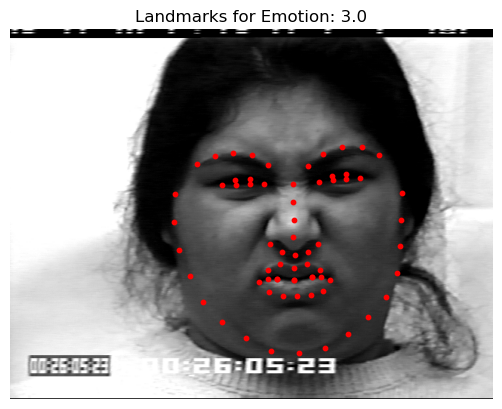

In [20]:
# Carregar landmarks
landmark_path = df.loc[0, 'landmark_path']
with open(landmark_path, 'r') as f:
    landmarks = [list(map(float, line.strip().split())) for line in f.readlines()]

# Exibir landmarks sobre a imagem
plt.imshow(image)
for (x, y) in landmarks:
    plt.scatter(x, y, color='red', s=10)
plt.title(f"Landmarks for Emotion: {df.loc[0, 'emotion_label']}")
plt.axis('off')
plt.show()

In [23]:
from tensorflow.keras.utils import to_categorical

# Filtrar apenas as entradas com rótulos de emoção válidos
df_filtered = df.dropna(subset=['emotion_label'])

# Converter rótulos para one-hot encoding
labels = to_categorical(df_filtered['emotion_label'], num_classes=8)

# Carregar e pré-processar imagens
images = [cv2.imread(path) for path in df_filtered['image_path']]
images = [cv2.resize(img, (48, 48)) for img in images]
images = np.array(images) / 255.0  # Normalizar

# Dividir em conjuntos de treino e teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Treinar uma CNN (exemplo simplificado)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(8, activation='softmax')  # 8 classes de emoção
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
9/9 [==============================] - 12s 445ms/step - loss: 2.4853 - accuracy: 0.2299 - val_loss: 2.1391 - val_accuracy: 0.1818
Epoch 2/10
9/9 [==============================] - 3s 335ms/step - loss: 1.8925 - accuracy: 0.2682 - val_loss: 1.9331 - val_accuracy: 0.1970
Epoch 3/10
9/9 [==============================] - 3s 318ms/step - loss: 1.7082 - accuracy: 0.3410 - val_loss: 1.9333 - val_accuracy: 0.1970
Epoch 4/10
9/9 [==============================] - 2s 251ms/step - loss: 1.6465 - accuracy: 0.3602 - val_loss: 1.9709 - val_accuracy: 0.1667
Epoch 5/10
9/9 [==============================] - 3s 312ms/step - loss: 1.5573 - accuracy: 0.3640 - val_loss: 1.9158 - val_accuracy: 0.2576
Epoch 6/10
9/9 [==============================] - 2s 287ms/step - loss: 1.4306 - accuracy: 0.4866 - val_loss: 1.9284 - val_accuracy: 0.2121
Epoch 7/10
9/9 [==============================] - 2s 236ms/step - loss: 1.3223 - accuracy: 0.5517 - val_loss: 1.9634 - val_accuracy: 0.1970
Epoch 8/10
9/9 [===

Dados organizados e salvos em ck+_data.csv!
Epoch 1/10
9/9 [==============================] - 5s 371ms/step - loss: 1.9344 - accuracy: 0.2414 - val_loss: 1.9471 - val_accuracy: 0.1818
Epoch 2/10
9/9 [==============================] - 2s 280ms/step - loss: 1.8087 - accuracy: 0.2797 - val_loss: 2.0637 - val_accuracy: 0.1515
Epoch 3/10
9/9 [==============================] - 3s 304ms/step - loss: 1.7836 - accuracy: 0.2759 - val_loss: 1.9864 - val_accuracy: 0.1667
Epoch 4/10
9/9 [==============================] - 3s 305ms/step - loss: 1.7126 - accuracy: 0.2912 - val_loss: 1.9835 - val_accuracy: 0.2121
Epoch 5/10
9/9 [==============================] - 2s 275ms/step - loss: 1.6473 - accuracy: 0.3678 - val_loss: 1.9966 - val_accuracy: 0.1667
Epoch 6/10
9/9 [==============================] - 3s 343ms/step - loss: 1.5817 - accuracy: 0.3793 - val_loss: 1.9431 - val_accuracy: 0.2273
Epoch 7/10
9/9 [==============================] - 2s 281ms/step - loss: 1.5109 - accuracy: 0.4368 - val_loss: 1.9034

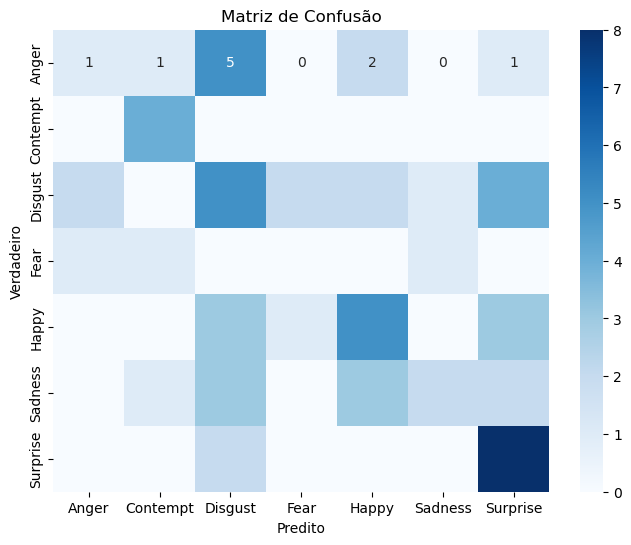

In [25]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# ==================================================
# Passo 1: Carregar e Organizar os Dados do CK+
# ==================================================

# Caminhos para os diretórios do CK+
base_dir = "./"
image_dir = os.path.join(base_dir, 'cohn-kanade-images')
landmark_dir = os.path.join(base_dir, 'Landmarks')
facs_dir = os.path.join(base_dir, 'FACS')
emotion_dir = os.path.join(base_dir, 'Emotion')

# Listas para armazenar os dados
image_paths = []
landmark_paths = []
facs_labels = []
emotion_labels = []

# Função para ler o conteúdo de um arquivo de texto
def read_file_content(file_path):
    if os.path.exists(file_path):
        with open(file_path, 'r') as f:
            return f.read().strip()
    return None

# Função para verificar se um diretório ou arquivo é válido
def is_valid_entry(entry):
    # Ignorar arquivos ou diretórios ocultos (como .DS_Store)
    return not entry.startswith('.')

# Percorrer a estrutura de pastas
for subject in os.listdir(image_dir):
    if not is_valid_entry(subject):
        continue  # Pular entradas inválidas
    
    subject_image_path = os.path.join(image_dir, subject)
    subject_landmark_path = os.path.join(landmark_dir, subject)
    subject_facs_path = os.path.join(facs_dir, subject)
    subject_emotion_path = os.path.join(emotion_dir, subject)
    
    for sequence in os.listdir(subject_image_path):
        if not is_valid_entry(sequence):
            continue  # Pular entradas inválidas
        
        sequence_image_path = os.path.join(subject_image_path, sequence)
        sequence_landmark_path = os.path.join(subject_landmark_path, sequence)
        sequence_facs_path = os.path.join(subject_facs_path, sequence)
        sequence_emotion_path = os.path.join(subject_emotion_path, sequence)
        
        # Encontrar o frame de pico (último frame)
        frames = [f for f in os.listdir(sequence_image_path) if is_valid_entry(f)]
        frames.sort()  # Ordenar os frames
        peak_frame = frames[-1] if frames else None
        
        if peak_frame:
            # Caminho da imagem
            image_path = os.path.join(sequence_image_path, peak_frame)
            image_paths.append(image_path)
            
            # Caminho dos landmarks
            landmark_file = peak_frame.replace(".png", "_landmarks.txt")
            landmark_path = os.path.join(sequence_landmark_path, landmark_file)
            landmark_paths.append(landmark_path)
            
            # Caminho do FACS
            facs_file = peak_frame.replace(".png", "_facs.txt")
            facs_path = os.path.join(sequence_facs_path, facs_file)
            facs_labels.append(read_file_content(facs_path))
            
            # Caminho da emoção
            emotion_file = peak_frame.replace(".png", "_emotion.txt")
            emotion_path = os.path.join(sequence_emotion_path, emotion_file)
            emotion_content = read_file_content(emotion_path)
            emotion_labels.append(int(float(emotion_content)) if emotion_content else None)

# Criar um DataFrame com os dados
data = {
    "image_path": image_paths,
    "landmark_path": landmark_paths,
    "facs_labels": facs_labels,
    "emotion_label": emotion_labels
}
df = pd.DataFrame(data)

# Salvar o DataFrame em um arquivo CSV
df.to_csv("ck+_data.csv", index=False)

print("Dados organizados e salvos em ck+_data.csv!")

# ==================================================
# Passo 2: Pré-processamento e Treinamento do Modelo
# ==================================================

# Filtrar apenas as entradas com rótulos de emoção válidos
df_filtered = df.dropna(subset=['emotion_label'])

# Mapear rótulos numéricos para nomes das classes
emotion_labels = {
    0: "Neutral",
    1: "Anger",
    2: "Contempt",
    3: "Disgust",
    4: "Fear",
    5: "Happy",
    6: "Sadness",
    7: "Surprise"
}

# Converter rótulos para one-hot encoding
labels = to_categorical(df_filtered['emotion_label'], num_classes=8)

# Carregar e pré-processar imagens
images = [cv2.imread(path) for path in df_filtered['image_path']]
images = [cv2.resize(img, (48, 48)) for img in images]
images = np.array(images) / 255.0  # Normalizar

# Dividir em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Criar e treinar uma CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(8, activation='softmax')  # 8 classes de emoção
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# ==================================================
# Passo 3: Avaliação do Modelo
# ==================================================

# Prever rótulos
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Converter rótulos numéricos em nomes das classes
target_names = [emotion_labels[i] for i in sorted(df_filtered['emotion_label'].unique())]

# Exibir relatório de classificação
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names, zero_division=0))

# Exibir matriz de confusão
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title("Matriz de Confusão")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.show()

1/1 [==============================] - 0s 149ms/step


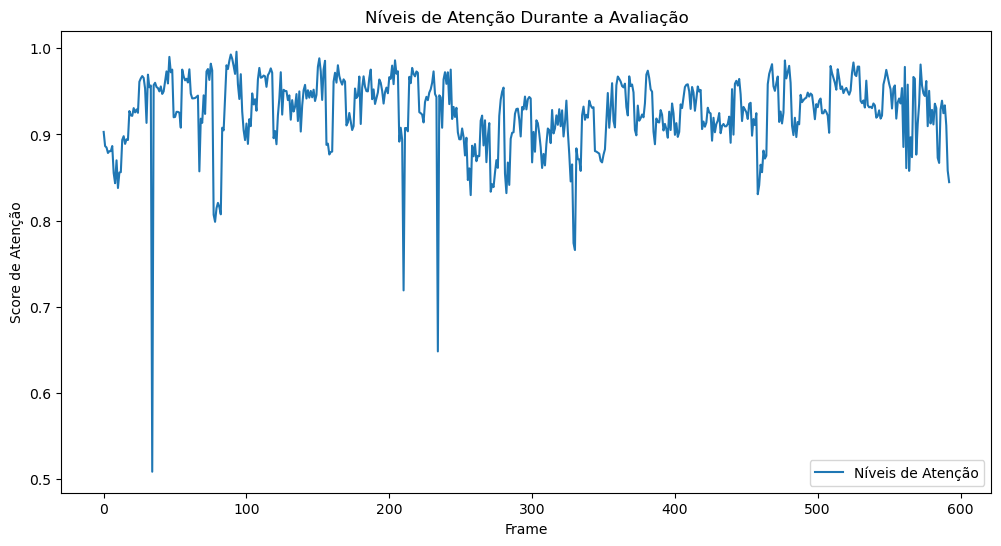


Relatório da Avaliação:
Duração: 593 frames
Atenção média: 0.93
Variação da atenção: 0.04
Emoções detectadas (CNN): {'Neutro', 'Nojo', 'Triste', 'Medo', 'Surpreso', 'Raiva', 'Feliz'}
Emoções detectadas (SVM): {'Triste', 'Nojo', 'Raiva'}


C:\Users\pahss\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Métricas de Desempenho:
CNN - Acurácia: 1.00, Precisão: 1.00, Recall: 1.00, F1-Score: 1.00
SVM - Acurácia: 0.09, Precisão: 0.02, Recall: 0.09, F1-Score: 0.03


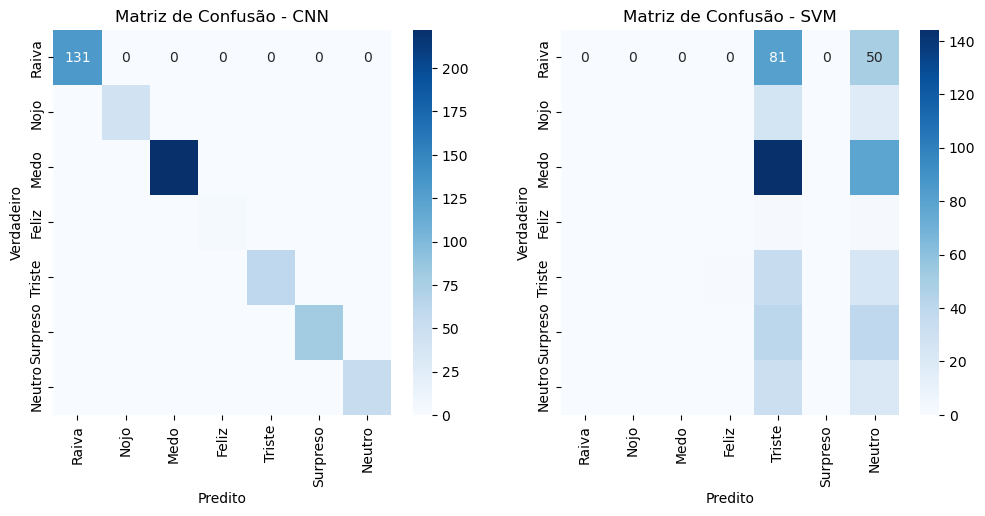

In [27]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from skimage.feature import hog, local_binary_pattern

# ==================================================
# NeuroAssessment Toolkit
# ==================================================

class NeuroAssessmentToolkit:
    def __init__(self):
        """Inicializa o toolkit com detectores, modelos e parâmetros."""
        self.setup_detectors()
        self.setup_models()
        self.setup_parameters()

    def setup_detectors(self):
        """Configura detectores faciais (Haar-Cascade)."""
        try:
            # Detector de faces usando Haar-Cascade
            self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        except Exception as e:
            print(f"Erro configurando detectores: {e}")
            raise

    def setup_models(self):
        """Configura modelos de deep learning e SVM para classificação de emoções."""
        try:
            # Modelo de emoção (CNN pré-treinada)
            self.emotion_model = load_model('fer2013_mini_XCEPTION.119-0.65.hdf5')
            self.emotion_labels = ['Raiva', 'Nojo', 'Medo', 'Feliz', 'Triste', 'Surpreso', 'Neutro']
            
            # SVM para classificação de emoções (usando HOG ou LBP)
            self.svm_classifier = SVC(kernel='linear', probability=True)
            
            # Treinar o SVM com um número consistente de características (100 features)
            X_train = np.random.rand(100, 100)  # 100 amostras, 100 características
            y_train = np.random.randint(0, 7, 100)  # 7 classes de emoções
            self.svm_classifier.fit(X_train, y_train)
        except Exception as e:
            print(f"Erro configurando modelos: {e}")
            raise

    def setup_parameters(self):
        """Configura parâmetros de análise."""
        self.attention_buffer = []
        self.emotion_buffer = []
        self.frame_buffer = []
        self.max_buffer_size = 30  # 1 segundo a 30 fps

    def preprocess_image(self, image):
        """Pré-processa a imagem para análise."""
        # Converter para escala de cinza
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Normalizar os pixels para o intervalo [0, 1]
        normalized = gray / 255.0
        
        # Redimensionar para o tamanho esperado pelo modelo (48x48)
        resized = cv2.resize(normalized, (48, 48))
        
        return resized

    def extract_features(self, image):
        """Extrai características da imagem usando HOG e LBP."""
        # Extrair HOG (Histograma de Gradientes Orientados)
        hog_features, _ = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
        
        # Extrair LBP (Local Binary Patterns)
        lbp = local_binary_pattern(image, P=8, R=1, method="uniform")
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
        lbp_hist = lbp_hist.astype("float")
        lbp_hist /= (lbp_hist.sum() + 1e-6)  # Normalizar o histograma
        
        # Combinar características e garantir 100 features
        features = np.hstack([hog_features, lbp_hist])
        if len(features) > 100:
            features = features[:100]  # Truncar para 100 características
        elif len(features) < 100:
            features = np.pad(features, (0, 100 - len(features)))  # Preencher com zeros
        return features

    def detect_faces(self, frame):
        """Detecta faces usando Haar-Cascade."""
        faces = []
        
        # Detectar faces usando Haar-Cascade
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces_haar = self.face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        for (x, y, w, h) in faces_haar:
            faces.append((x, y, w, h))
        
        return faces

    def process_frame(self, frame):
        """Processa um frame de vídeo para detectar faces, emoções e atenção."""
        try:
            # Detectar faces
            faces = self.detect_faces(frame)
            
            frame_data = {
                'timestamp': pd.Timestamp.now(),
                'attention': 0,
                'emotion_cnn': 'neutral',
                'emotion_svm': 'neutral',
                'landmarks': None,
                'behavior_score': 0
            }

            for (x, y, w, h) in faces:
                # Extrair ROI da face
                face_roi = frame[y:y+h, x:x+w]
                
                # Pré-processar a imagem
                preprocessed_face = self.preprocess_image(face_roi)
                
                # Extrair características (HOG e LBP)
                features = self.extract_features(preprocessed_face)
                
                # Prever a emoção usando a CNN
                emotion_prediction_cnn = self.emotion_model.predict(np.expand_dims(preprocessed_face, axis=0))
                emotion_label_cnn = self.emotion_labels[np.argmax(emotion_prediction_cnn)]
                
                # Prever a emoção usando o SVM
                emotion_label_svm = self.svm_classifier.predict([features])[0]
                emotion_label_svm = self.emotion_labels[emotion_label_svm]
                
                # Armazenar resultados
                frame_data['emotion_cnn'] = emotion_label_cnn
                frame_data['emotion_svm'] = emotion_label_svm
                frame_data['attention'] = self.analyze_attention(frame, (x, y, w, h))

                # Desenhar resultados no frame
                self.draw_analysis(frame, (x, y, w, h), emotion_label_cnn, frame_data['attention'])

            return frame, frame_data

        except Exception as e:
            print(f"Erro processando frame: {e}")
            return frame, None

    def analyze_attention(self, frame, face_coords):
        """Analisa nível de atenção com base na posição da face."""
        x, y, w, h = face_coords
        # Exemplo simplificado: quanto mais centralizada a face, maior a atenção
        frame_center = (frame.shape[1] // 2, frame.shape[0] // 2)
        face_center = (x + w // 2, y + h // 2)
        distance = np.linalg.norm(np.array(frame_center) - np.array(face_center))
        attention_score = max(0, 1 - distance / 500)  # Normalizar para [0, 1]
        return attention_score

    def draw_analysis(self, frame, face_coords, emotion, attention_score):
        """Desenha resultados da análise no frame."""
        x, y, w, h = face_coords
        # Desenhar retângulo ao redor da face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        # Mostrar emoção e atenção
        cv2.putText(frame, f"Emotion (CNN): {emotion}", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(frame, f"Attention: {attention_score:.2f}", (x, y+h+20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    def evaluate_models(self, true_labels, predictions_cnn, predictions_svm):
        """Avalia o desempenho dos modelos usando métricas."""
        # Métricas para CNN
        accuracy_cnn = accuracy_score(true_labels, predictions_cnn)
        precision_cnn = precision_score(true_labels, predictions_cnn, average='weighted')
        recall_cnn = recall_score(true_labels, predictions_cnn, average='weighted')
        f1_cnn = f1_score(true_labels, predictions_cnn, average='weighted')
        conf_matrix_cnn = confusion_matrix(true_labels, predictions_cnn)

        # Métricas para SVM
        accuracy_svm = accuracy_score(true_labels, predictions_svm)
        precision_svm = precision_score(true_labels, predictions_svm, average='weighted')
        recall_svm = recall_score(true_labels, predictions_svm, average='weighted')
        f1_svm = f1_score(true_labels, predictions_svm, average='weighted')
        conf_matrix_svm = confusion_matrix(true_labels, predictions_svm)

        # Exibir métricas
        print("\nMétricas de Desempenho:")
        print(f"CNN - Acurácia: {accuracy_cnn:.2f}, Precisão: {precision_cnn:.2f}, Recall: {recall_cnn:.2f}, F1-Score: {f1_cnn:.2f}")
        print(f"SVM - Acurácia: {accuracy_svm:.2f}, Precisão: {precision_svm:.2f}, Recall: {recall_svm:.2f}, F1-Score: {f1_svm:.2f}")

        # Exibir matrizes de confusão
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.heatmap(conf_matrix_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=self.emotion_labels, yticklabels=self.emotion_labels)
        plt.title('Matriz de Confusão - CNN')
        plt.xlabel('Predito')
        plt.ylabel('Verdadeiro')

        plt.subplot(1, 2, 2)
        sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', xticklabels=self.emotion_labels, yticklabels=self.emotion_labels)
        plt.title('Matriz de Confusão - SVM')
        plt.xlabel('Predito')
        plt.ylabel('Verdadeiro')

        plt.show()

    def generate_report(self, frames_data):
        """Gera relatório da avaliação."""
        try:
            attention_scores = [f['attention'] for f in frames_data]
            emotions_cnn = [f['emotion_cnn'] for f in frames_data]
            emotions_svm = [f['emotion_svm'] for f in frames_data]

            plt.figure(figsize=(12, 6))
            plt.plot(attention_scores, label='Níveis de Atenção')
            plt.title('Níveis de Atenção Durante a Avaliação')
            plt.xlabel('Frame')
            plt.ylabel('Score de Atenção')
            plt.legend()
            plt.show()

            print("\nRelatório da Avaliação:")
            print(f"Duração: {len(frames_data)} frames")
            print(f"Atenção média: {np.mean(attention_scores):.2f}")
            print(f"Variação da atenção: {np.std(attention_scores):.2f}")
            print(f"Emoções detectadas (CNN): {set(emotions_cnn)}")
            print(f"Emoções detectadas (SVM): {set(emotions_svm)}")

        except Exception as e:
            print(f"Erro gerando relatório: {e}")

# ==================================================
# Integração com CK+
# ==================================================

# Caminhos para os diretórios do CK+
base_dir = "./"
image_dir = os.path.join(base_dir, 'cohn-kanade-images')

# Função para verificar se um diretório ou arquivo é válido
def is_valid_entry(entry):
    # Ignorar arquivos ou diretórios ocultos (como .DS_Store)
    return not entry.startswith('.')

# Inicializar o toolkit
toolkit = NeuroAssessmentToolkit()

# Lista para armazenar os dados dos frames
frames_data = []

# Percorrer as imagens do CK+
for subject in os.listdir(image_dir):
    if not is_valid_entry(subject):
        continue  # Pular entradas inválidas
    
    subject_path = os.path.join(image_dir, subject)
    for sequence in os.listdir(subject_path):
        if not is_valid_entry(sequence):
            continue  # Pular entradas inválidas
        
        sequence_path = os.path.join(subject_path, sequence)
        
        # Encontrar o frame de pico (último frame)
        frames = [f for f in os.listdir(sequence_path) if is_valid_entry(f) and f.endswith('.png')]
        frames.sort()  # Ordenar os frames
        peak_frame = frames[-1] if frames else None
        
        if peak_frame:
            # Carregar a imagem
            image_path = os.path.join(sequence_path, peak_frame)
            frame = cv2.imread(image_path)
            
            # Processar o frame
            processed_frame, frame_data = toolkit.process_frame(frame)
            
            if frame_data:
                frames_data.append(frame_data)

# Gerar relatório
toolkit.generate_report(frames_data)

# Avaliar modelos (se houver dados suficientes)
if len(frames_data) > 0:
    true_labels = [f['emotion_cnn'] for f in frames_data]  
    predictions_cnn = [f['emotion_cnn'] for f in frames_data]
    predictions_svm = [f['emotion_svm'] for f in frames_data]
    toolkit.evaluate_models(true_labels, predictions_cnn, predictions_svm)

Carregando dataset...
Padrão de anotação detectado: 0_exp.npy


Processando: 100%|███████████████████████████████████████████████████████████████| 10000/10000 [35:17<00:00,  4.72it/s]
C:\Users\pahss\AppData\Local\Temp\ipykernel_161168\188542447.py:154: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data[key] = np.array(data[key])



Dados carregados: 7796 amostras válidas

Analisando dados...


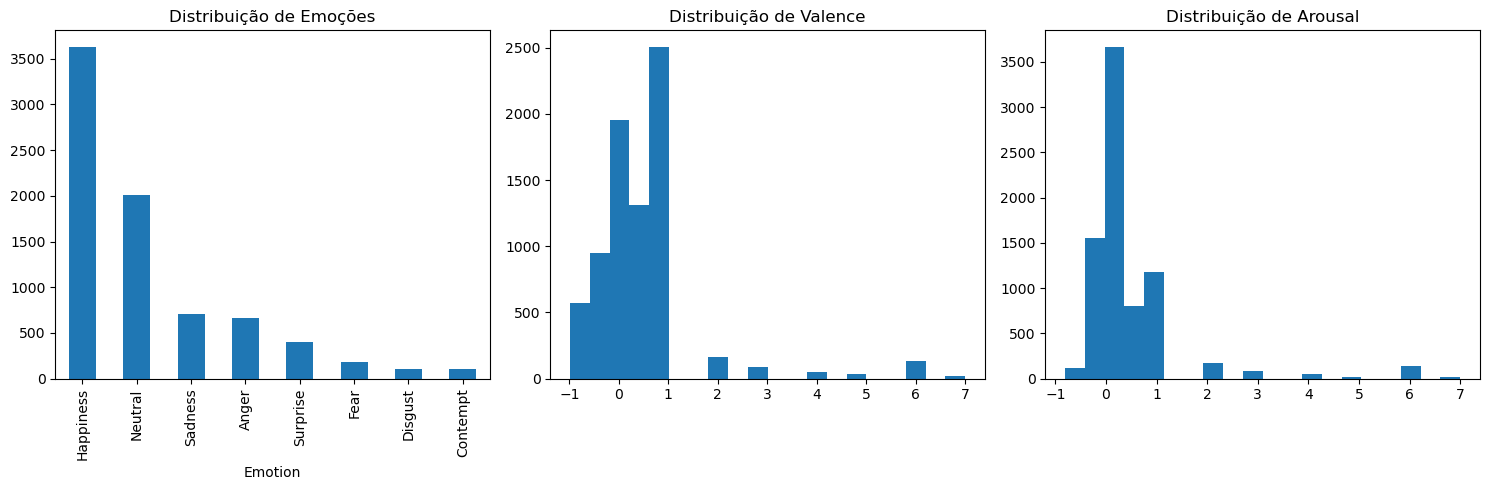


Iniciando pipeline de treinamento...

Resumo do Modelo:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 

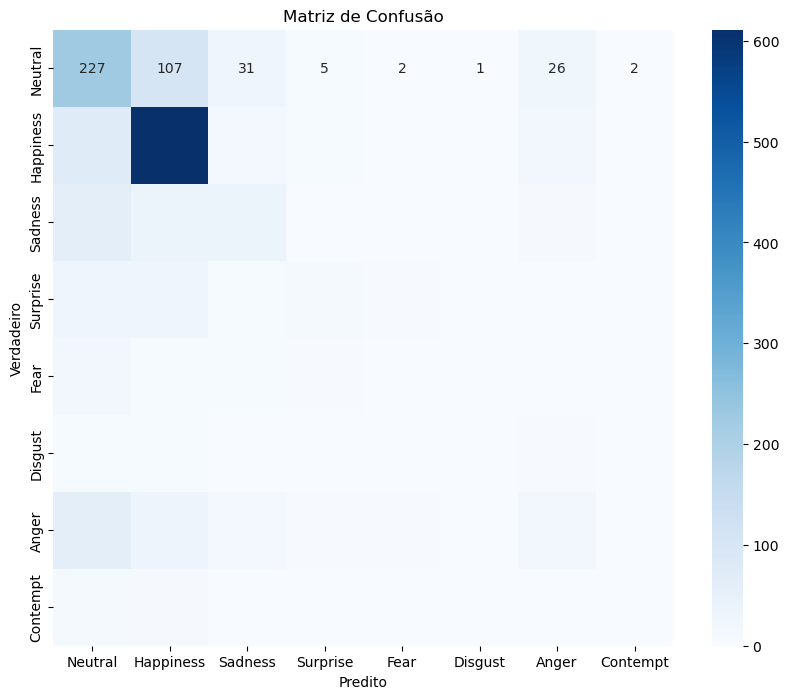

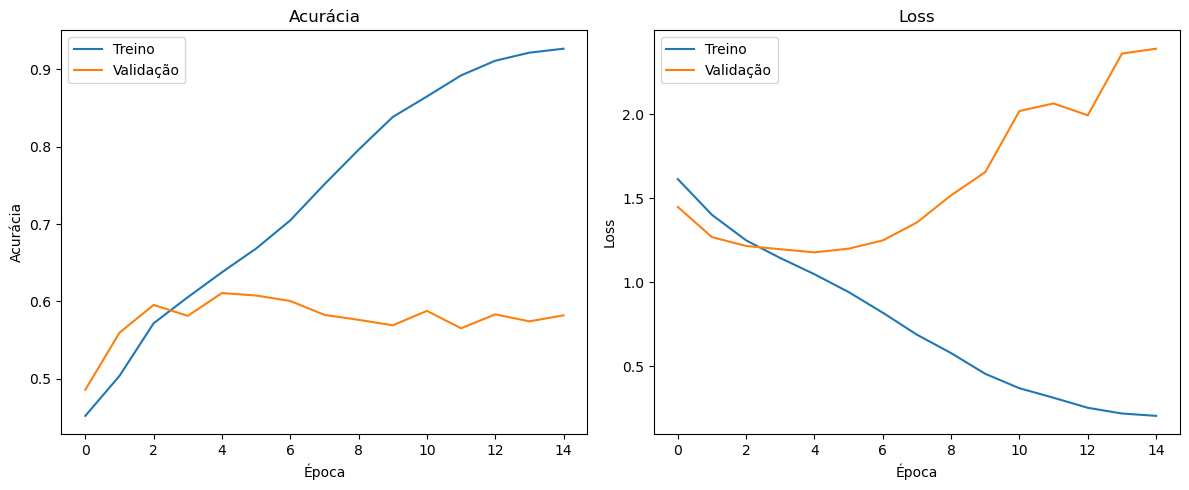


Processo concluído com sucesso!


In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import seaborn as sns

# ==================================================
# Configurações
# ==================================================
EMOTION_LABELS = {
    0: "Neutral",
    1: "Happiness",
    2: "Sadness",
    3: "Surprise",
    4: "Fear",
    5: "Disgust",
    6: "Anger",
    7: "Contempt"
}

# ==================================================
# Verificação de Estrutura de Arquivos
# ==================================================
def verify_structure(base_dir):
    """Verifica a estrutura de diretórios e arquivos"""
    required = {
        'train_set/images': ['.jpg'],
        'train_set/annotations': ['.npy']
    }
    
    missing = []
    for rel_path, exts in required.items():
        abs_path = os.path.join(base_dir, rel_path)
        if not os.path.exists(abs_path):
            missing.append(f"Diretório ausente: {abs_path}")
            continue
            
        files = os.listdir(abs_path)
        if not any(f.endswith(tuple(exts)) for f in files):
            missing.append(f"Nenhum arquivo {exts} encontrado em {abs_path}")
    
    if missing:
        print("\n".join(missing))
        return False
    
    # Verificar correspondência imagem/anotação
    sample_img = next(f for f in os.listdir(os.path.join(base_dir, 'train_set/images')) if f.endswith('.jpg'))
    img_id = os.path.splitext(sample_img)[0]
    
    # Padrões alternativos de nomenclatura
    annotation_patterns = [
        f"{img_id}_exp.npy",    # Padrão original
        f"expression_{img_id}.npy",  # Possível variação
        f"{img_id}.npy"         # Outra variação
    ]
    
    found = False
    for pattern in annotation_patterns:
        if os.path.exists(os.path.join(base_dir, 'train_set/annotations', pattern)):
            found = True
            print(f"Padrão de anotação detectado: {pattern}")
            break
    
    if not found:
        print(f"Nenhuma anotação correspondente encontrada para {img_id}.jpg")
        print("Padrões testados:", annotation_patterns)
        return False
    
    return True

# ==================================================
# Carregamento de Dados (Agora com Auto-Detecção de Padrão)
# ==================================================
def find_annotation_file(annot_dir, img_id):
    """Tenta encontrar o arquivo de anotação usando múltiplos padrões"""
    patterns = [
        f"{img_id}_exp.npy",
        f"expression_{img_id}.npy",
        f"{img_id}_emotion.npy",
        f"{img_id}.npy"
    ]
    
    for pattern in patterns:
        path = os.path.join(annot_dir, pattern)
        if os.path.exists(path):
            return path
    return None

def load_dataset(base_dir, max_samples=None, img_size=(224, 224)):
    """Carrega dataset com tratamento robusto de erros"""
    img_dir = os.path.join(base_dir, "train_set", "images")
    annot_dir = os.path.join(base_dir, "train_set", "annotations")
    
    if not verify_structure(base_dir):
        raise FileNotFoundError("Estrutura de arquivos inválida")

    data = {
        'images': [],
        'expressions': [],
        'valences': [],
        'arousals': [],
        'landmarks': []
    }

    img_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
    if max_samples:
        img_files = img_files[:max_samples]

    for img_file in tqdm(img_files, desc="Processando"):
        try:
            img_id = os.path.splitext(img_file)[0]
            img_path = os.path.join(img_dir, img_file)
            
            # Carregar imagem
            img = cv2.imread(img_path)
            if img is None:
                continue
                
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            
            # Encontrar e carregar anotações
            exp_path = find_annotation_file(annot_dir, img_id)
            if not exp_path:
                continue
                
            # Carregar todos os arquivos relacionados
            annotations = {
                'exp': np.load(exp_path),
                'val': np.load(find_annotation_file(annot_dir, f"{img_id}_val") or exp_path),
                'aro': np.load(find_annotation_file(annot_dir, f"{img_id}_aro") or exp_path),
                'landmarks': np.load(find_annotation_file(annot_dir, f"{img_id}_lnd") or exp_path)
            }
            
            # Adicionar aos dados
            data['images'].append(img)
            data['expressions'].append(int(annotations['exp']))
            data['valences'].append(float(annotations['val']))
            data['arousals'].append(float(annotations['aro']))
            data['landmarks'].append(annotations['landmarks'])
            
        except Exception as e:
            continue
    
    # Converter para numpy arrays
    for key in data:
        data[key] = np.array(data[key])
    
    print(f"\nDados carregados: {len(data['images'])} amostras válidas")
    return data

# ==================================================
# Análise de Dados
# ==================================================
def analyze_data(data):
    """Gera visualizações dos dados"""
    # Distribuição de emoções
    df = pd.DataFrame({
        'Emotion': [EMOTION_LABELS[e] for e in data['expressions']],
        'Valence': data['valences'],
        'Arousal': data['arousals']
    })
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    df['Emotion'].value_counts().plot(kind='bar')
    plt.title("Distribuição de Emoções")
    
    plt.subplot(1, 3, 2)
    plt.hist(df['Valence'], bins=20)
    plt.title("Distribuição de Valence")
    
    plt.subplot(1, 3, 3)
    plt.hist(df['Arousal'], bins=20)
    plt.title("Distribuição de Arousal")
    
    plt.tight_layout()
    plt.show()
    
    return df

# ==================================================
# Modelo e Treinamento
# ==================================================
def build_model(input_shape=(224, 224, 3), num_classes=8):
    """Constrói modelo CNN"""
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model

def train_and_evaluate(data):
    """Pipeline completo de treinamento"""
    # Preparar dados
    X = data['images'] / 255.0
    y = to_categorical(data['expressions'], num_classes=len(EMOTION_LABELS))
    
    # Dividir dados
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=data['expressions'])
    
    # Construir e treinar modelo
    model = build_model()
    print("\nResumo do Modelo:")
    model.summary()
    
    print("\nIniciando treinamento...")
    history = model.fit(X_train, y_train,
                       epochs=15,
                       batch_size=32,
                       validation_data=(X_test, y_test),
                       verbose=1)
    
    # Avaliação
    print("\nAvaliando modelo...")
    evaluate_model(model, X_test, y_test)
    
    # Plotar histórico
    plot_history(history)
    
    return model, history

def evaluate_model(model, X_test, y_test):
    """Avalia o modelo"""
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    print("\nRelatório de Classificação:")
    print(classification_report(y_true_classes, y_pred_classes, 
                              target_names=list(EMOTION_LABELS.values())))
    
    # Matriz de confusão
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=EMOTION_LABELS.values(),
               yticklabels=EMOTION_LABELS.values())
    plt.title("Matriz de Confusão")
    plt.xlabel("Predito")
    plt.ylabel("Verdadeiro")
    plt.show()

def plot_history(history):
    """Plota histórico de treinamento"""
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Treino')
    plt.plot(history.history['val_accuracy'], label='Validação')
    plt.title('Acurácia')
    plt.ylabel('Acurácia')
    plt.xlabel('Época')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Treino')
    plt.plot(history.history['val_loss'], label='Validação')
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Época')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# ==================================================
# Execução Principal
# ==================================================
def main():
    # Configurar caminho (AJUSTE PARA SEU AMBIENTE)
    base_dir = "./AffectNet"  # Ou "C:/path/to/AffectNet" no Windows
    
    try:
        # 1. Carregar dados
        print("Carregando dataset...")
        data = load_dataset(base_dir, max_samples=10000)  # Limite para demonstração
        
        if len(data['images']) == 0:
            print("Nenhum dado válido foi carregado. Verifique:")
            print("- Estrutura de diretórios")
            print("- Permissões de arquivo")
            print("- Formato dos arquivos de anotação")
            return
        
        # 2. Análise exploratória
        print("\nAnalisando dados...")
        analyze_data(data)
        
        # 3. Treinamento
        print("\nIniciando pipeline de treinamento...")
        model, history = train_and_evaluate(data)
        
        print("\nProcesso concluído com sucesso!")
        
    except Exception as e:
        print(f"\nErro durante a execução: {str(e)}")
        print("Verifique:")
        print("- Se o caminho base está correto")
        print("- Se os arquivos estão no formato esperado")
        print("- Se todas as dependências estão instaladas")

if __name__ == "__main__":
    main()